Random state = 3, noise = 0.18 for makemoons and random state for train test split = 12

In [1]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.interpolate import CubicSpline, PchipInterpolator
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 100  # Increase animation size limit

class GradientSMPA(BaseEstimator, ClassifierMixin):
    """
    Smooth Manifold Projection Algorithm with gradient-based updates.
    Uses a loss function and numerical gradients to adjust spline control points.
    """
    def __init__(self, learning_rate=0.005, epochs=50, random_state=7, verbose=False,
                 lambda_reg=0.01, patience=5, decay_factor=0.5, min_learning_rate=1e-6,
                 n_control_points=5, smoothing_factor=0.1, spline_type='cubic', epsilon=1e-6):
        """
        Initialize the GradientSMPA classifier.

        Parameters:
        -----------
        lambda_reg : float, default=0.01
            Regularization strength for control point spacing
        epsilon : float, default=1e-6
            Perturbation size for numerical gradient computation
        (Other parameters same as ImprovedSMPA)
        """
        self.learning_rate = learning_rate
        self.initial_learning_rate = learning_rate
        self.epochs = epochs
        self.random_state = random_state
        self.verbose = verbose
        self.lambda_reg = lambda_reg
        self.patience = patience
        self.decay_factor = decay_factor
        self.min_learning_rate = min_learning_rate
        self.n_control_points = n_control_points
        self.smoothing_factor = smoothing_factor
        self.spline_type = spline_type
        self.epsilon = epsilon

        if spline_type not in ['cubic', 'pchip']:
            raise ValueError("spline_type must be 'cubic' or 'pchip'")

        self.error_history_ = []
        self.learning_rate_history_ = []
        self.control_point_history = []
        np.random.seed(random_state)

    def _calculate_class_means(self, X, y):
        mask_1 = y == 1
        self.m1 = X[mask_1].mean(axis=0)
        self.m0 = X[~mask_1].mean(axis=0)

    def _initialize_control_points(self, X):
        x_min, x_max = X[:, 0].min(), X[:, 0].max()
        y_min, y_max = X[:, 1].min(), X[:, 1].max()
        y_range = y_max - y_min
        self.control_x = np.linspace(x_min, x_max, self.n_control_points)
        y_mid = (self.m0[1] + self.m1[1]) / 2
        self.control_y = np.random.uniform(y_mid - y_range * 0.05, y_mid + y_range * 0.05, self.n_control_points)
        if self.n_control_points > 2:
            self.control_y[0] = self.control_y[1]  # Still enforce boundary stability if needed
            self.control_y[-1] = self.control_y[-2]
        self.initial_control_x = self.control_x.copy()
        self.initial_control_y = self.control_y.copy()
        self.control_point_history.append((self.control_x.copy(), self.control_y.copy()))

    def _fit_spline(self):
        if self.spline_type == 'cubic':
            self.spline = CubicSpline(self.control_x, self.control_y, bc_type='clamped')
        else:
            self.spline = PchipInterpolator(self.control_x, self.control_y)

    def _calculate_displacement(self, X):
        spline_y = self.spline(X[:, 0])
        return X[:, 1] - spline_y

    def _update_pseudo_labels(self, X, y, epoch):
        if hasattr(self, 'locked_class_1_pseudo') and epoch >= self.lock_epoch:
            return np.where(y == 1, self.locked_class_1_pseudo, -self.locked_class_1_pseudo)
        m1_displacement = self._calculate_displacement(self.m1.reshape(1, -1))[0]
        self.class_1_pseudo = 1 if m1_displacement > 0 else -1
        self.class_0_pseudo = -self.class_1_pseudo
        if epoch == self.lock_epoch:
            self.locked_class_1_pseudo = self.class_1_pseudo
        return np.where(y == 1, self.class_1_pseudo, self.class_0_pseudo)

    def _compute_gradients(self, X, y, epoch):
        """Compute numerical gradients of the loss w.r.t. control points."""
        displacements = self._calculate_displacement(X)
        pseudo_labels = self._update_pseudo_labels(X, y, epoch)  # Pass epoch here
        errors = (displacements * pseudo_labels <= 0)
        grad_x = np.zeros_like(self.control_x)
        grad_y = np.zeros_like(self.control_y)

        for i in np.where(errors)[0]:
            ti = 1 if y[i] == 1 else -1
            sign_theta = self.class_1_pseudo
            base_spline = self.spline(X[i, 0])

            for j in range(len(self.control_x)):
                self.control_x[j] += self.epsilon
                self._fit_spline()
                perturbed_spline_x = self.spline(X[i, 0])
                grad_x[j] += (ti * sign_theta) * (perturbed_spline_x - base_spline) / self.epsilon
                self.control_x[j] -= self.epsilon

                self.control_y[j] += self.epsilon
                self._fit_spline()
                perturbed_spline_y = self.spline(X[i, 0])
                grad_y[j] += (ti * sign_theta) * (perturbed_spline_y - base_spline) / self.epsilon
                self.control_y[j] -= self.epsilon

            self._fit_spline()  # Reset

        for j in range(len(self.control_x)):
            if j > 0:
                grad_x[j] += 2 * self.lambda_reg * (self.control_x[j] - self.control_x[j-1])
                grad_y[j] += 2 * self.lambda_reg * (self.control_y[j] - self.control_y[j-1])
            if j < len(self.control_x) - 1:
                grad_x[j] -= 2 * self.lambda_reg * (self.control_x[j+1] - self.control_x[j])
                grad_y[j] -= 2 * self.lambda_reg * (self.control_y[j+1] - self.control_y[j])

        return grad_x, grad_y

    def fit(self, X, y):
        if not set(np.unique(y)).issubset({0, 1}):
            raise ValueError("Labels must be 0 and 1")
        if X.shape[1] != 2:
            raise ValueError("2D-only algorithm for now!")

        X = np.asarray(X)
        y = np.asarray(y)
        self._calculate_class_means(X, y)
        self._initialize_control_points(X)
        self._fit_spline()

        self.control_point_history = []
        self.error_history_ = []
        self.displacement_history = []
        self.pseudo_label_history = []
        self.lock_epoch = 10  # Lock pseudo-labels after 10 epochs
        self.momentum = 0.9   # Add momentum
        prev_grad_x = np.zeros_like(self.control_x)
        prev_grad_y = np.zeros_like(self.control_y)

        best_error = float('inf')
        best_control_x = None
        best_control_y = None
        best_class_1_pseudo = None
        patience_counter = 0
        current_learning_rate = self.initial_learning_rate

        for epoch in range(self.epochs):
            self._fit_spline()
            pseudo_labels = self._update_pseudo_labels(X, y, epoch)
            displacements = self._calculate_displacement(X)
            errors = (displacements * pseudo_labels <= 0)
            error_count = np.sum(errors)

            self.control_point_history.append((self.control_x.copy(), self.control_y.copy()))
            self.error_history_.append(error_count)
            self.displacement_history.append(displacements.copy())
            self.pseudo_label_history.append(pseudo_labels.copy())

            if self.verbose and epoch % 5 == 0:
                print(f"Epoch {epoch}: Errors = {error_count}, LR = {current_learning_rate:.6f}")

            if error_count < best_error:
                best_error = error_count
                best_control_x = self.control_x.copy()
                best_control_y = self.control_y.copy()
                best_class_1_pseudo = self.class_1_pseudo
                patience_counter = 0
                self.best_epoch = epoch
            else:
                patience_counter += 1
                if patience_counter >= self.patience:
                    current_learning_rate = max(current_learning_rate * self.decay_factor, self.min_learning_rate)
                    patience_counter = 0
                    if current_learning_rate == self.min_learning_rate:
                        if self.verbose:
                            print(f"Min learning rate reached at epoch {epoch}")
                        break

            grad_x, grad_y = self._compute_gradients(X, y, epoch)
            # Apply momentum
            grad_x = self.momentum * prev_grad_x + (1 - self.momentum) * grad_x
            grad_y = self.momentum * prev_grad_y + (1 - self.momentum) * grad_y
            self.control_x -= current_learning_rate * grad_x
            self.control_y -= current_learning_rate * grad_y
            prev_grad_x, prev_grad_y = grad_x, grad_y

        self.control_x = best_control_x
        self.control_y = best_control_y
        self._fit_spline()
        self.class_1_pseudo = best_class_1_pseudo
        return self

    def predict(self, X):
        X = np.asarray(X)
        displacements = self._calculate_displacement(X)
        return np.where(displacements > 0,
                        1 if self.class_1_pseudo > 0 else 0,
                        0 if self.class_1_pseudo > 0 else 1)

    def predict_proba(self, X):
        X = np.asarray(X)
        displacements = self._calculate_displacement(X)
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))
        raw_probs = sigmoid(displacements * self.class_1_pseudo * 0.5)
        if self.class_1_pseudo > 0:
            probs = np.column_stack([1 - raw_probs, raw_probs])
        else:
            probs = np.column_stack([raw_probs, 1 - raw_probs])
        return probs

    def plot_convergence(self, figsize=(12, 5)):
        try:
            import matplotlib.pyplot as plt
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
            ax1.plot(self.error_history_, 'b-', label='Errors')
            ax1.set_title('Error Convergence')
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Number of Errors')
            ax1.grid(True)
            ax2.plot(self.learning_rate_history_, 'r-', label='Learning Rate')
            ax2.set_title('Learning Rate Decay')
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Learning Rate')
            ax2.set_yscale('log')
            ax2.grid(True)
            plt.tight_layout()
            return fig
        except ImportError:
            print("Install matplotlib with 'pip install matplotlib'!")
            return None

    def plot_boundary(self, X, y, figsize=(8, 6)):
        try:
            import matplotlib.pyplot as plt
            import numpy as np
            fig = plt.figure(figsize=figsize)

            # Scatter plot of the data points
            plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.5)

            # Define x-range for plotting
            x_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)

            # Plot initial spline using initial control points
            if self.spline_type == 'cubic':
                initial_spline = CubicSpline(self.initial_control_x, self.initial_control_y, bc_type='clamped')
            else:  # 'pchip'
                initial_spline = PchipInterpolator(self.initial_control_x, self.initial_control_y)
            y_initial = initial_spline(x_range)
            plt.plot(x_range, y_initial, 'r--', label='Initial Boundary', alpha=0.7)

            # Plot final spline (best model’s spline, already fitted)
            y_final = self.spline(x_range)
            plt.plot(x_range, y_final, 'g-', label='Final Boundary')

            # Plot control points
            plt.scatter(self.initial_control_x, self.initial_control_y, c='orange', marker='o',
                        label='Initial Control Points', alpha=0.7)
            plt.scatter(self.control_x, self.control_y, c='k', marker='x',
                        label='Final Control Points')

            # Finalize plot
            plt.legend()
            plt.title('GradientSMPA Decision Boundary: Initial vs Final')
            plt.xlabel('Feature 1')
            plt.ylabel('Feature 2')
            return fig

        except ImportError:
            print("Install matplotlib with 'pip install matplotlib'!")
            return None

    def animate_training(self, X, y, interval=200, save_path=None, every_nth_epoch=1, figsize=(10, 8), padding_factor=0.1):
        """
        Create an animation of the spline's evolution during training for GradientSMPA.

        Parameters:
        -----------
        X, y : Training data
        interval : Time between frames in milliseconds
        save_path : If provided, save the animation to this path
        every_nth_epoch : Only show every nth epoch (to reduce animation size)
        figsize : Figure size
        padding_factor : Factor to add padding around the data

        Returns:
        --------
        Animation object that can be displayed in Jupyter/Colab
        """
        try:
            import matplotlib.pyplot as plt
            import numpy as np
            from matplotlib.animation import FuncAnimation

            # Check if history exists (we’ll add this in fit)
            if not hasattr(self, 'control_point_history') or not self.control_point_history:
                print("No training history found. Run fit() with history tracking first.")
                return None

            # Set up the figure and axis
            fig, ax = plt.subplots(figsize=figsize)

            # Prepare data ranges with padding
            x_min, x_max = X[:, 0].min(), X[:, 0].max()
            y_min, y_max = X[:, 1].min(), X[:, 1].max()
            x_range = x_max - x_min
            y_range = y_max - y_min
            x_min -= x_range * padding_factor
            x_max += x_range * padding_factor
            y_min -= y_range * padding_factor
            y_max += y_range * padding_factor

            # Create x-range for spline evaluation
            x_range_points = np.linspace(x_min, x_max, 200)

            # Static scatter plot of data
            scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.6, s=50, zorder=5)

            # Initialize dynamic elements
            spline_line, = ax.plot([], [], 'g-', lw=2, zorder=2)
            control_points = ax.scatter([], [], c='k', marker='x', s=100, zorder=4)
            error_points = ax.scatter([], [], color='yellow', edgecolor='black', marker='*', s=150, alpha=0.7, zorder=6)
            info_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, fontsize=12,
                                bbox=dict(facecolor='white', alpha=0.7))

            # Set plot limits and labels
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_min, y_max)
            ax.set_title(f'GradientSMPA Training Evolution ({self.spline_type} spline)')
            ax.set_xlabel('Feature 1')
            ax.set_ylabel('Feature 2')
            ax.grid(True, linestyle='--', alpha=0.3)

            # Subset of epochs to animate
            epochs_to_show = list(range(0, len(self.control_point_history), every_nth_epoch))

            def init():
                spline_line.set_data([], [])
                control_points.set_offsets(np.empty((0, 2)))
                error_points.set_offsets(np.empty((0, 2)))
                info_text.set_text('')
                return spline_line, control_points, error_points, info_text

            def update(frame_idx):
                epoch = epochs_to_show[frame_idx] if frame_idx < len(epochs_to_show) else 0
                if epoch >= len(self.control_point_history):
                    return spline_line, control_points, error_points, info_text

                # Get control points and fit spline
                control_x, control_y = self.control_point_history[epoch]
                if self.spline_type == 'cubic':
                    spline = CubicSpline(control_x, control_y, bc_type='clamped')
                else:
                    spline = PchipInterpolator(control_x, control_y)

                y_spline = spline(x_range_points)
                # Clip extreme values
                y_spline = np.clip(y_spline, y_min, y_max)

                # Update spline line
                spline_line.set_data(x_range_points, y_spline)

                # Update control points
                control_points.set_offsets(np.column_stack((control_x, control_y)))

                # Update error points
                if epoch < len(self.error_history_):
                    errors = self.error_history_[epoch]
                    pseudo_labels = self.pseudo_label_history[epoch]
                    displacements = self.displacement_history[epoch]
                    error_indices = np.where(displacements * pseudo_labels <= 0)[0]
                    if len(error_indices) > 0:
                        error_points.set_offsets(X[error_indices])
                    else:
                        error_points.set_offsets(np.empty((0, 2)))

                # Update info text
                error_count = self.error_history_[epoch] if epoch < len(self.error_history_) else "N/A"
                if hasattr(self, 'best_epoch') and epoch == self.best_epoch:
                    info_text.set_text(f'Epoch: {epoch} | Errors: {error_count} | BEST MODEL')
                    info_text.set_bbox(dict(facecolor='lightgreen', alpha=0.7))
                else:
                    info_text.set_text(f'Epoch: {epoch} | Errors: {error_count}')
                    info_text.set_bbox(dict(facecolor='white', alpha=0.7))

                return spline_line, control_points, error_points, info_text

            # Create animation
            ani = FuncAnimation(fig, update, frames=len(epochs_to_show),
                                init_func=init, blit=True, interval=interval)

            # Save if requested
            if save_path:
                ani.save(save_path, writer='pillow', dpi=100)
                print(f"Animation saved to {save_path}")

            plt.close(fig)
            return ani

        except ImportError as e:
            print(f"Error: {e}. Make sure you have matplotlib installed.")
            return None

In [2]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

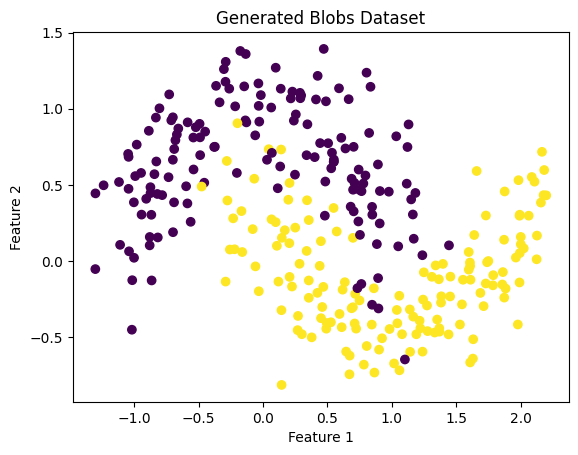

In [3]:
X, y = make_moons(n_samples=300, random_state = 3, noise = 0.20)
plt.scatter(X[:, 0], X[:, 1], c = y)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Generated Blobs Dataset")
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 12)

scaler = MinMaxScaler(feature_range=(-100,100))
X_train_minmax = scaler.fit_transform(X_train)
X_test_minmax = scaler.transform(X_test)

In [12]:
model = GradientSMPA(
    learning_rate=0.1,        # Moderate step size for gradient updates
    epochs=200,                # Enough iterations to converge
    random_state=11,           # Reproducibility
    verbose=True,              # Track progress
    lambda_reg=0.00001,           # Light regularization to prevent wild spline jumps
    patience=10,                # Standard patience for LR decay
    decay_factor=0.99,
    min_learning_rate=1e-6,    # Stop when LR gets tiny
    n_control_points=5,        # Flexible but not overkill
    smoothing_factor=0.000001,      # Your original smoothing, works well
    spline_type='pchip',       # Smooth and differentiable
    epsilon=1e-8               # Small perturbation for numerical gradients
)

In [13]:
model.fit(X_train_minmax, y_train)

Epoch 0: Errors = 46, LR = 0.100000
Epoch 5: Errors = 44, LR = 0.100000
Epoch 10: Errors = 43, LR = 0.100000
Epoch 15: Errors = 42, LR = 0.100000
Epoch 20: Errors = 40, LR = 0.100000
Epoch 25: Errors = 37, LR = 0.100000
Epoch 30: Errors = 36, LR = 0.100000
Epoch 35: Errors = 33, LR = 0.100000
Epoch 40: Errors = 30, LR = 0.100000
Epoch 45: Errors = 26, LR = 0.100000
Epoch 50: Errors = 23, LR = 0.100000
Epoch 55: Errors = 22, LR = 0.100000
Epoch 60: Errors = 19, LR = 0.100000
Epoch 65: Errors = 19, LR = 0.100000
Epoch 70: Errors = 19, LR = 0.100000
Epoch 75: Errors = 18, LR = 0.099000
Epoch 80: Errors = 19, LR = 0.099000
Epoch 85: Errors = 19, LR = 0.099000
Epoch 90: Errors = 17, LR = 0.098010
Epoch 95: Errors = 16, LR = 0.098010
Epoch 100: Errors = 16, LR = 0.098010
Epoch 105: Errors = 15, LR = 0.098010
Epoch 110: Errors = 16, LR = 0.097030
Epoch 115: Errors = 18, LR = 0.097030
Epoch 120: Errors = 18, LR = 0.096060
Epoch 125: Errors = 17, LR = 0.096060
Epoch 130: Errors = 17, LR = 0.095

GradientSMPA(decay_factor=0.99, epochs=200, epsilon=1e-08, lambda_reg=1e-05,
             learning_rate=0.1, patience=10, random_state=11,
             smoothing_factor=1e-06, spline_type='pchip', verbose=True)

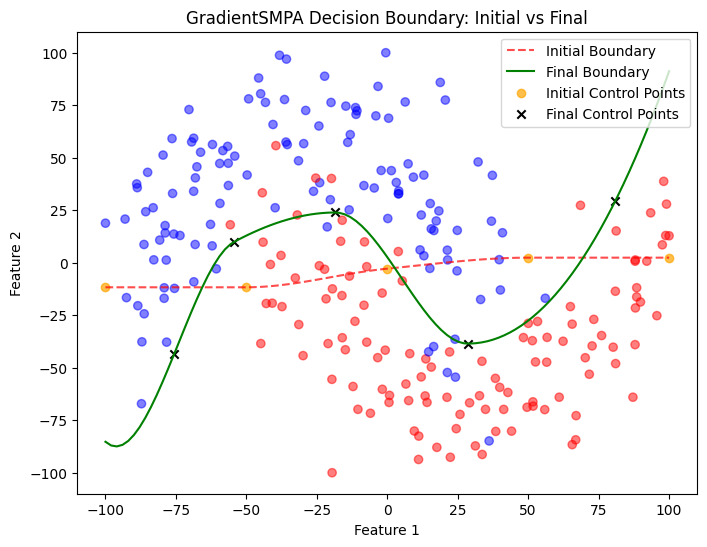

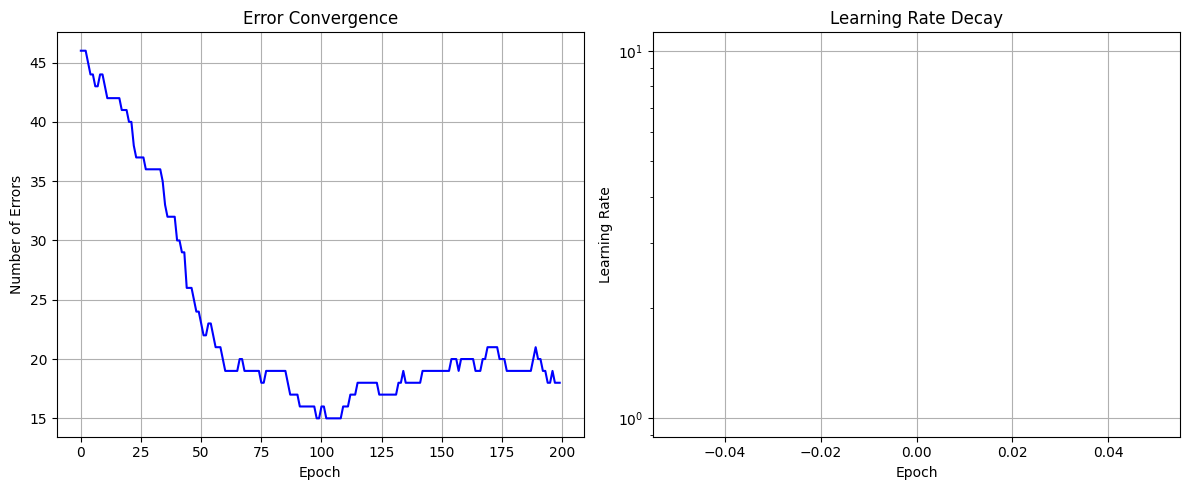

In [14]:
# Plot the decision boundary and convergence
model.plot_boundary(X_train_minmax, y_train)
model.plot_convergence()
plt.show()

In [15]:
from sklearn.metrics import classification_report

In [16]:
print("\nClassification Report:")
print(classification_report(y_test,model.predict(X_test_minmax)))
cr = classification_report(y_test, model.predict(X_test_minmax))


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        28
           1       0.97      0.97      0.97        32

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



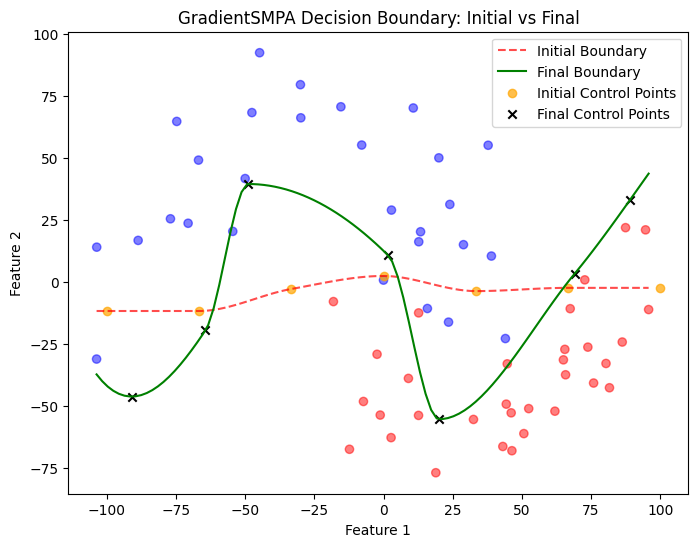

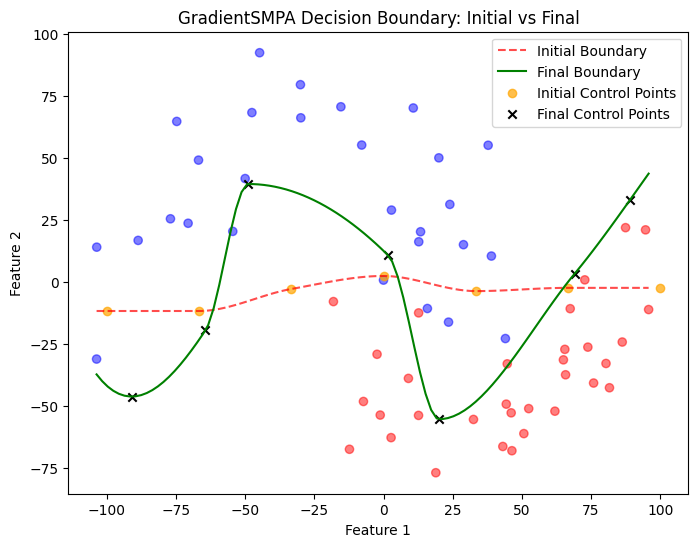

In [9]:
model.plot_boundary(X_test_minmax, y_test)

In [10]:
print(min(model.error_history_))

11


KeyboardInterrupt: 

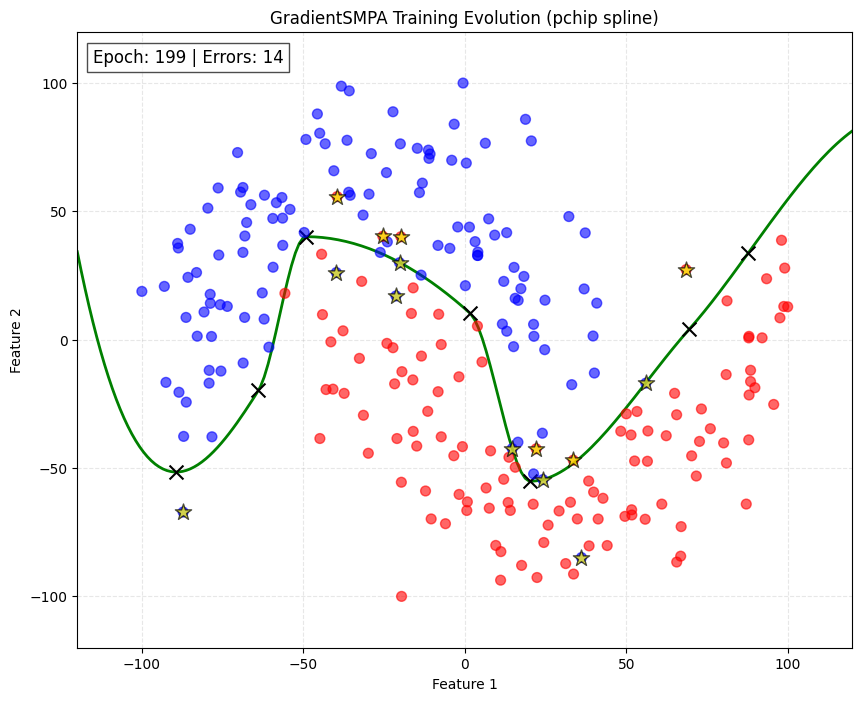

In [11]:
ani = model.animate_training(X_train_minmax, y_train, every_nth_epoch=1, save_path="./animations/gradient_learning_pchip.gif")